In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils.utils import load_data, remove_zero_features, load_confounders, standardize, generate_label_stats
from utils.utils import generate_undersampled_set, generate_oversampled_set
from utils.plot_utils import plot_demographics, plot_diagnosis_frequency, plot_umap_cluster

from umap import UMAP

In [2]:
# Load data for classification task
subject_data, features, diagnoses = load_data('classification')

In [3]:
C = load_confounders(subject_data, case='raw')
D = diagnoses.iloc[:,1:]

In [5]:
# Remove zero features
F = remove_zero_features(features.iloc[:,1:])
# Standardize
X = standardize(F)
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
# Remove ID column
Y = D
print(f"Number of labels: {Y.shape[1]}")

Number of samples: 2815
Number of features: 922
Number of labels: 13


# 1. Demographics

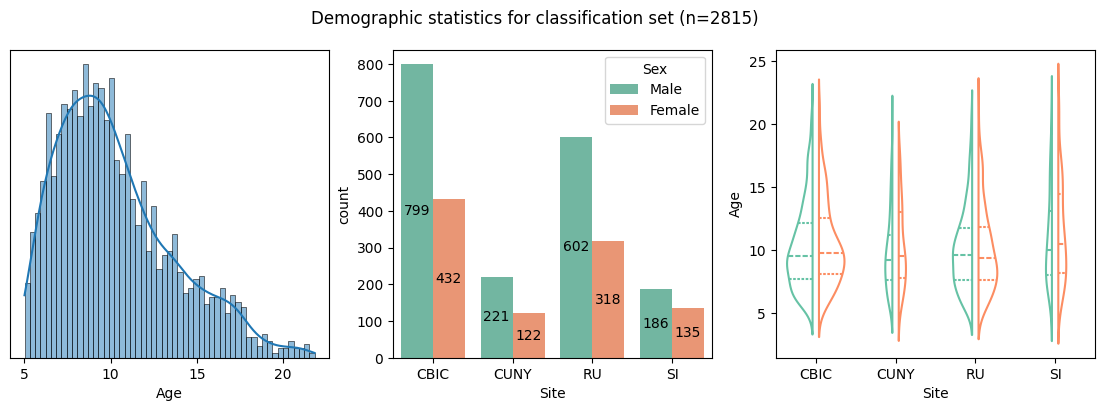

In [4]:
plot_demographics(C, 'classification')

# 2. Diagnostic labels

## 2.1. Label statistics (for individual labels)

In [12]:
df_tmp = pd.concat([C.iloc[:,:3], D], axis=1)

In [19]:
# Select the columns to keep
id_vars = ['Age', 'Sex', 'Site']

# Select the columns to melt
value_vars = df_tmp.columns[df_tmp.columns.get_loc('Trauma_And_Stress_RelatedDisorders'):]

# Use melt function to reshape the DataFrame
df1 = df_tmp.melt(id_vars=id_vars, value_vars=value_vars, var_name='Diagnosis', value_name='value')

# Filter out rows where value is 0
df1 = df1[df1['value'] != 0]

# Drop the 'value' column as it's not needed anymore
df1 = df1.drop(columns='value')

In [22]:
df2 = df_tmp[D.eq(0).all(axis=1)]
df2 = df2.iloc[:,:3]
df2['Diagnosis'] = 'No_Condition'

In [23]:
data = pd.concat([df1, df2], axis=0)
data

,Age,Sex,Site,Diagnosis
4,16.335843,Female,CBIC,Trauma_And_Stress_RelatedDisorders
47,8.672484,Male,CBIC,Trauma_And_Stress_RelatedDisorders
53,11.856490,Male,CBIC,Trauma_And_Stress_RelatedDisorders
100,8.797969,Male,CBIC,Trauma_And_Stress_RelatedDisorders
151,8.874515,Male,CBIC,Trauma_And_Stress_RelatedDisorders
...,...,...,...,...
2775,8.064111,Male,SI,No_Condition
2786,8.633584,Male,SI,No_Condition
2791,7.048254,Female,SI,No_Condition
2794,13.545402,Male,SI,No_Condition


In [ ]:
distinct_diagnosis = data['Diagnosis'].unique().tolist()


In [98]:
diagnosis_acronyms = ['TSD', 'DD', 'ADHD', 'MD', 'ASD', 'CD', 'OD', 'SLD', 'OCD', 'D', 'ID', 'ED', 'AD', 'NC']

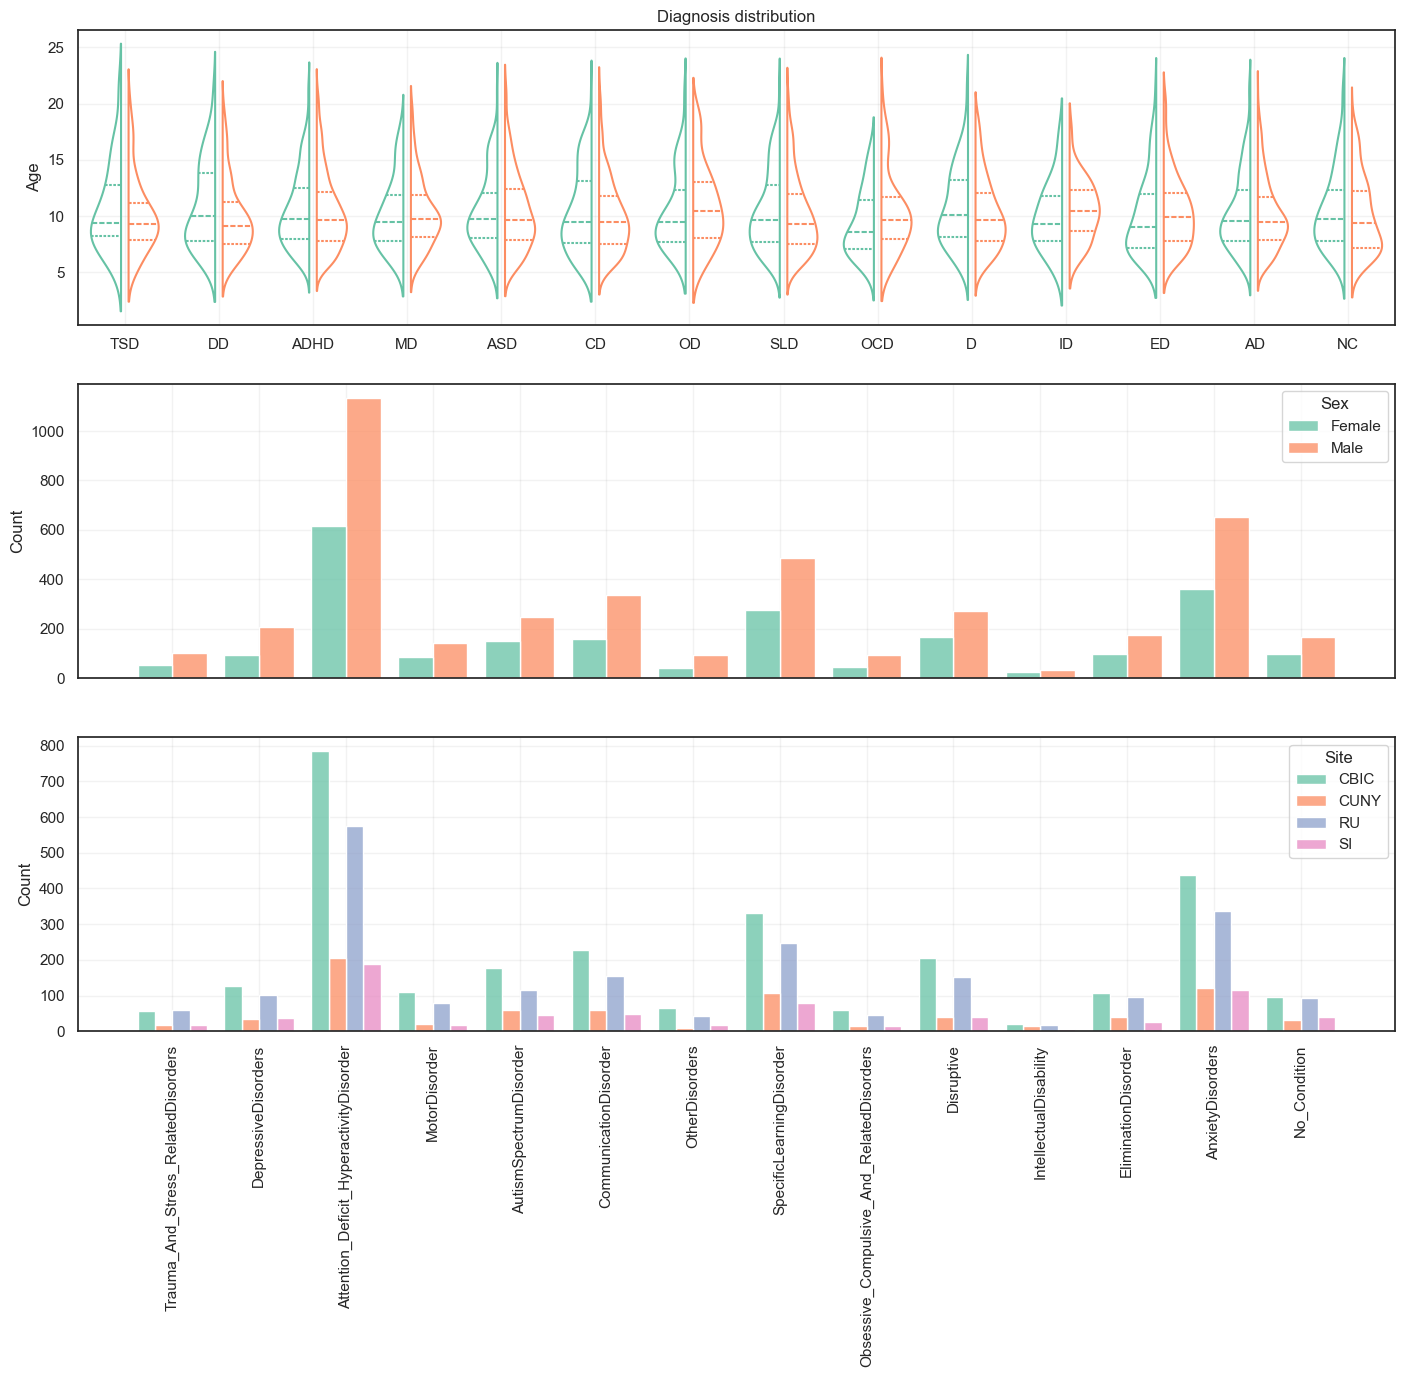

In [104]:
fig = plt.figure(1,(17,13))

#plt.subplots_adjust(hspace=0.05)
sns.set_theme(style="white")

plt.subplot(3,1,1)
sb1 = sns.violinplot(data=data, x='Diagnosis', y='Age', hue="Sex", palette='Set2', density_norm='width', inner='quart', legend=None, fill=False, split=True, gap=0.2)
sb1.set_axisbelow(True)
sb1.grid(which='both', color='gray', alpha=0.1)
sb1.set_xticks(range(14), diagnosis_acronyms)
sb1.set(xlabel=None)
plt.title("Diagnosis distribution")

plt.subplot(3,1,2)
sb2 = sns.histplot(data=data, x='Diagnosis', hue="Sex", palette='Set2', multiple='dodge', shrink=0.8)
sb2.set_axisbelow(True)
sb2.grid(which='both', color='gray', alpha=0.1)
sb2.set_yticks(range(0,1200,200))
sb2.set_xticks(range(14), [])
sb2.set(xlabel=None)

plt.subplot(3,1,3)
sb3 = sns.histplot(data=data, x='Diagnosis', hue="Site", palette='Set2', multiple='dodge', shrink=0.8)
sb3.grid(which='both', color='gray', alpha=0.1)
sb3.set_xticks(range(14), data['Diagnosis'].unique().tolist(), rotation=90)
sb3.set(xlabel=None)


plt.show()
#fig.savefig(plot_path + f'demographics_{set_name}.svg', bbox_inches='tight')


<Axes: xlabel='Diagnosis', ylabel='Age'>

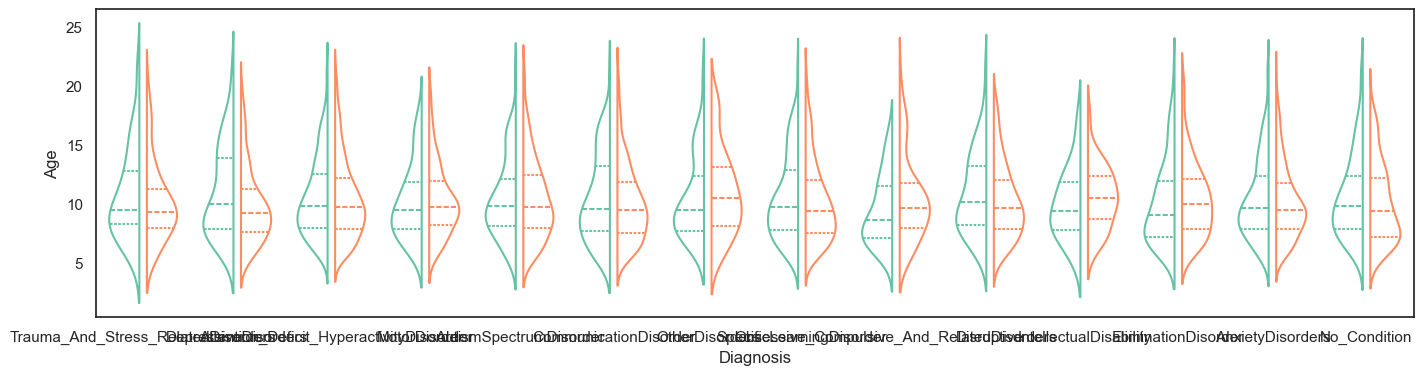

In [24]:
sns.set_theme(style="white")
plt.figure(1,(17,4))
sns.violinplot(data=data, x='Diagnosis', y='Age', hue="Sex", palette='Set2', density_norm='width', inner='quart', legend=None, fill=False, split=True, gap=0.2)

<Axes: xlabel='Diagnosis', ylabel='Count'>

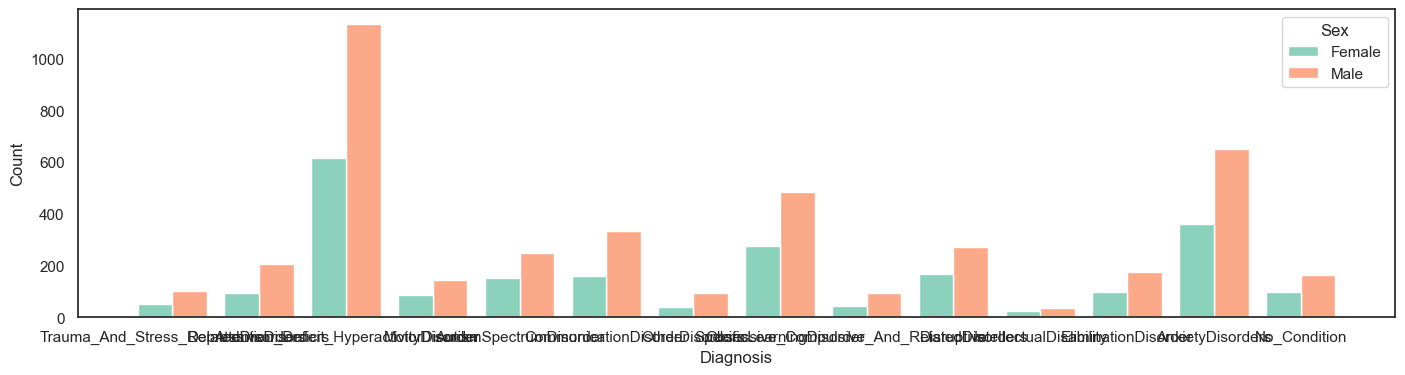

In [25]:
sns.set_theme(style="white")
plt.figure(1,(17,4))
sns.histplot(data=data, x='Diagnosis', hue="Sex", palette='Set2', multiple='dodge', shrink=0.8)

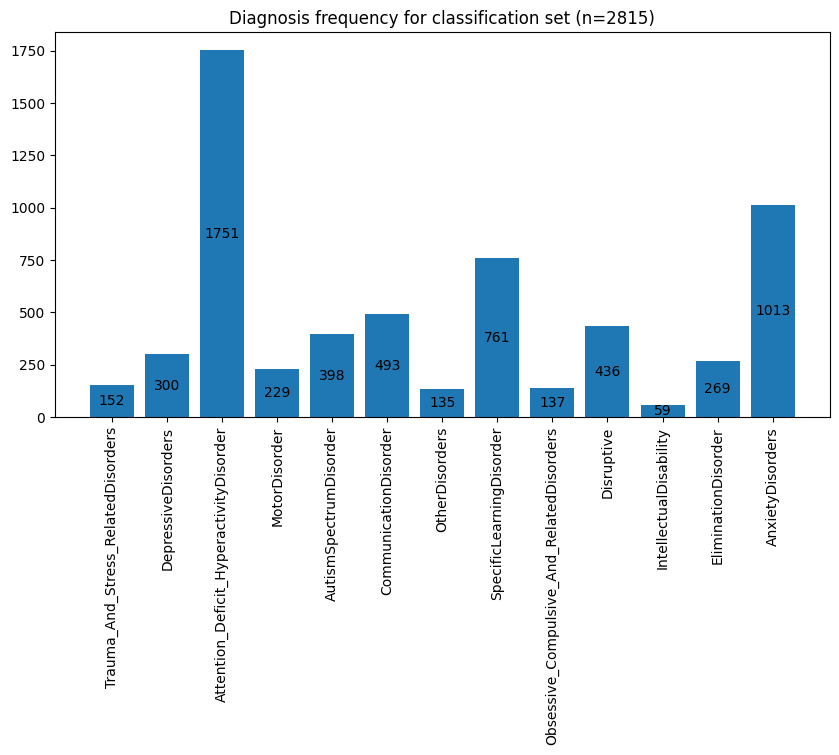

In [7]:
plot_diagnosis_frequency(D, 'classification')

In [8]:
stats, mean_ir = generate_label_stats(D, mean_ir=True)

In [9]:
stats

,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,0.053996,152,11.519737
DepressiveDisorders,0.106572,300,5.836667
Attention_Deficit_HyperactivityDisorder,0.622025,1751,1.000000
MotorDisorder,0.081350,229,7.646288
AutismSpectrumDisorder,0.141385,398,4.399497
CommunicationDisorder,0.175133,493,3.551724
OtherDisorders,0.047957,135,12.970370
SpecificLearningDisorder,0.270337,761,2.300920
Obsessive_Compulsive_And_RelatedDisorders,0.048668,137,12.781022
Disruptive,0.154885,436,4.016055


In [10]:
print(f"Mean imbalance ratio: {mean_ir:.2f}")

Mean imbalance ratio: 8.00


## 2.2. Set statistics (for label sets)
A label set with cardinality greater 1 is a case of comorbidity

In [11]:
print(f"Number of uniqe lable sets: {D.apply(tuple, axis=1).nunique()}")
print(f"Mean set cardinality: {D.sum(axis=1).mean():.2f}")

Number of uniqe lable sets: 396
Mean set cardinality: 2.18


In [12]:
head_size = 10
print(f"{head_size} most frequent label sets:")
combinations = D.apply(lambda x: tuple(x), axis=1).value_counts()
combinations.head(head_size)

10 most frequent label sets:


(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    316
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    260
(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    116
(0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    109
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    100
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    100
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)     83
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)     68
(0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1)     52
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)     48
Name: count, dtype: int64

In [13]:
print("Frequency of sets with cardinality 1 (occurence of one single disorder):")
combinations = D.apply(lambda x: tuple(x), axis=1).value_counts()
combinations = combinations[combinations.index.map(lambda x: sum(x) == 1)]
combinations

Frequency of sets with cardinality 1 (occurence of one single disorder):


(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)    316
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)    100
(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)    100
(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)     48
(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)     24
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0)     23
(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)     22
(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)     22
(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0)     17
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)     15
(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)     14
(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)      9
(0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0)      7
Name: count, dtype: int64

## 2.3. Low-dimensional representation
Project the data to a lower-dimensional space using UMAP (embedding method)

### 2.3.1 Regular dataset

([], [])

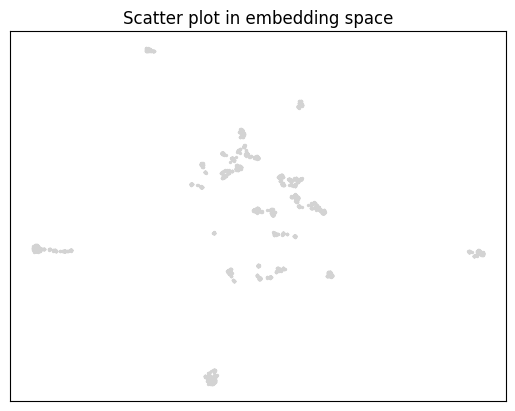

In [10]:
prj1 = UMAP()
ebd = prj1.fit_transform(D)
plt.scatter(ebd[:,0], ebd[:,1], s=2, color='lightgrey')
plt.title('Scatter plot in embedding space')
plt.xticks([], [])
plt.yticks([], [])

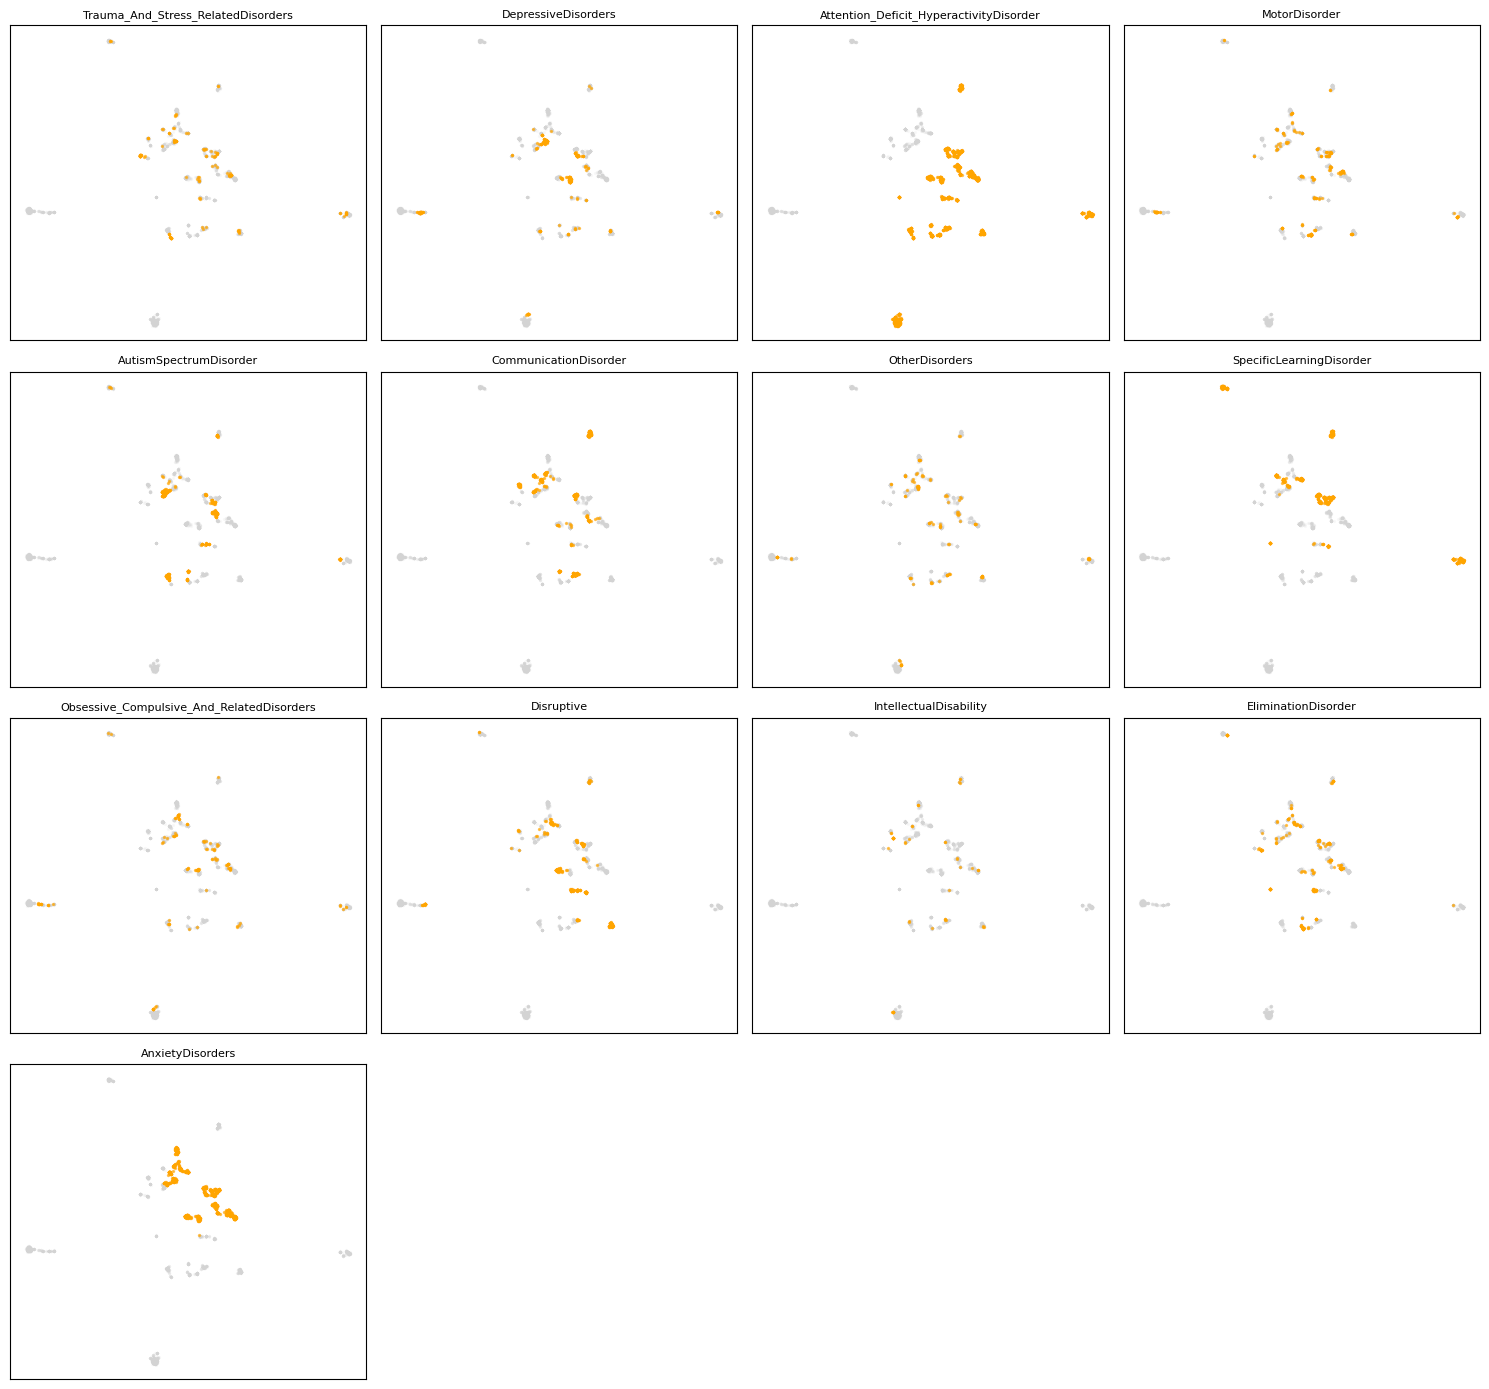

In [11]:
plot_umap_cluster(D, 'regular', ebd)

### 2.3.2. Undersampled set

In [7]:
X_under, Y_under = generate_undersampled_set(X, Y)
label_stats, mean_ir = generate_label_stats(Y_under, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 2.7700915195670985


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,69,0.069277,3.260870
DepressiveDisorders,103,0.103414,2.184466
Attention_Deficit_HyperactivityDisorder,225,0.225904,1.000000
MotorDisorder,68,0.068273,3.308824
AutismSpectrumDisorder,117,0.117470,1.923077
CommunicationDisorder,105,0.105422,2.142857
OtherDisorders,55,0.055221,4.090909
SpecificLearningDisorder,177,0.177711,1.271186
Obsessive_Compulsive_And_RelatedDisorders,52,0.052209,4.326923
Disruptive,103,0.103414,2.184466


([], [])

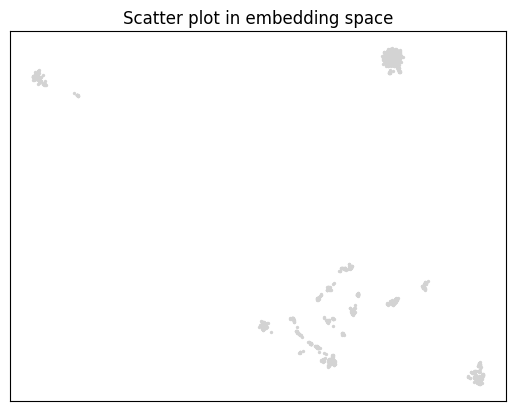

In [13]:
prj1 = UMAP()
ebd = prj1.fit_transform(Y_under)
plt.scatter(ebd[:,0], ebd[:,1], s=2, color='lightgrey')
plt.title('Scatter plot in embedding space')
plt.xticks([], [])
plt.yticks([], [])

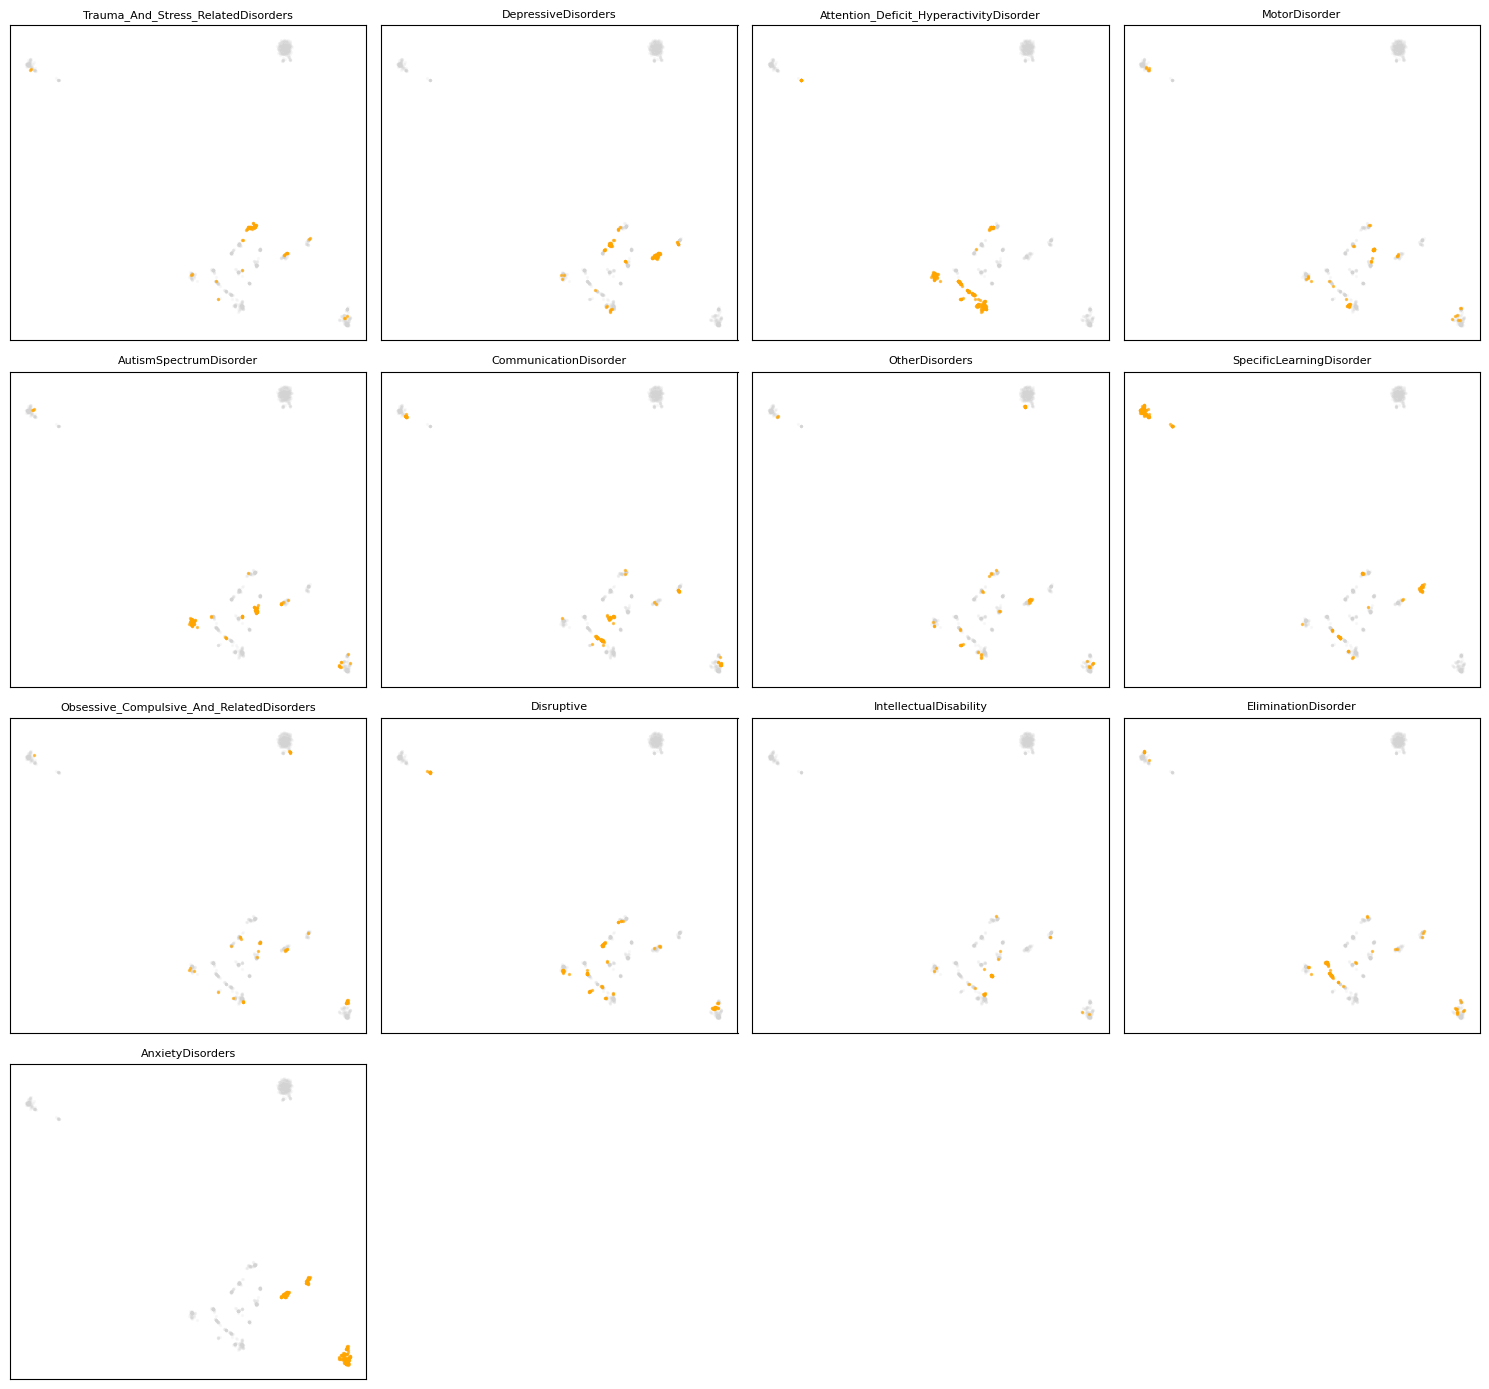

In [14]:
plot_umap_cluster(Y_under, 'undersampled', ebd)

### 2.3.3. Oversampled set

In [15]:
X_over, Y_over = generate_oversampled_set(X, Y)
label_stats, mean_ir = generate_label_stats(Y_over, True)
print(f"Mean imbalance ratio: {mean_ir}")
label_stats

Mean imbalance ratio: 1.6092872677464145


,Absolute frequency,Relative frequency,Imbalance ratio
Trauma_And_Stress_RelatedDisorders,2580,0.116174,1.923256
DepressiveDisorders,3170,0.142741,1.565300
Attention_Deficit_HyperactivityDisorder,4582,0.206322,1.082933
MotorDisorder,3134,0.141120,1.583280
AutismSpectrumDisorder,3689,0.166111,1.345080
CommunicationDisorder,4431,0.199523,1.119838
OtherDisorders,2320,0.104467,2.138793
SpecificLearningDisorder,4962,0.223433,1.000000
Obsessive_Compulsive_And_RelatedDisorders,2668,0.120137,1.859820
Disruptive,2801,0.126126,1.771510


([], [])

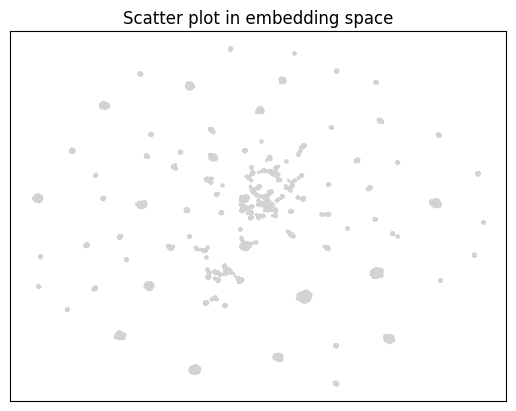

In [16]:
prj1 = UMAP()
ebd = prj1.fit_transform(Y_over)
plt.scatter(ebd[:,0], ebd[:,1], s=2, color='lightgrey')
plt.title('Scatter plot in embedding space')
plt.xticks([], [])
plt.yticks([], [])

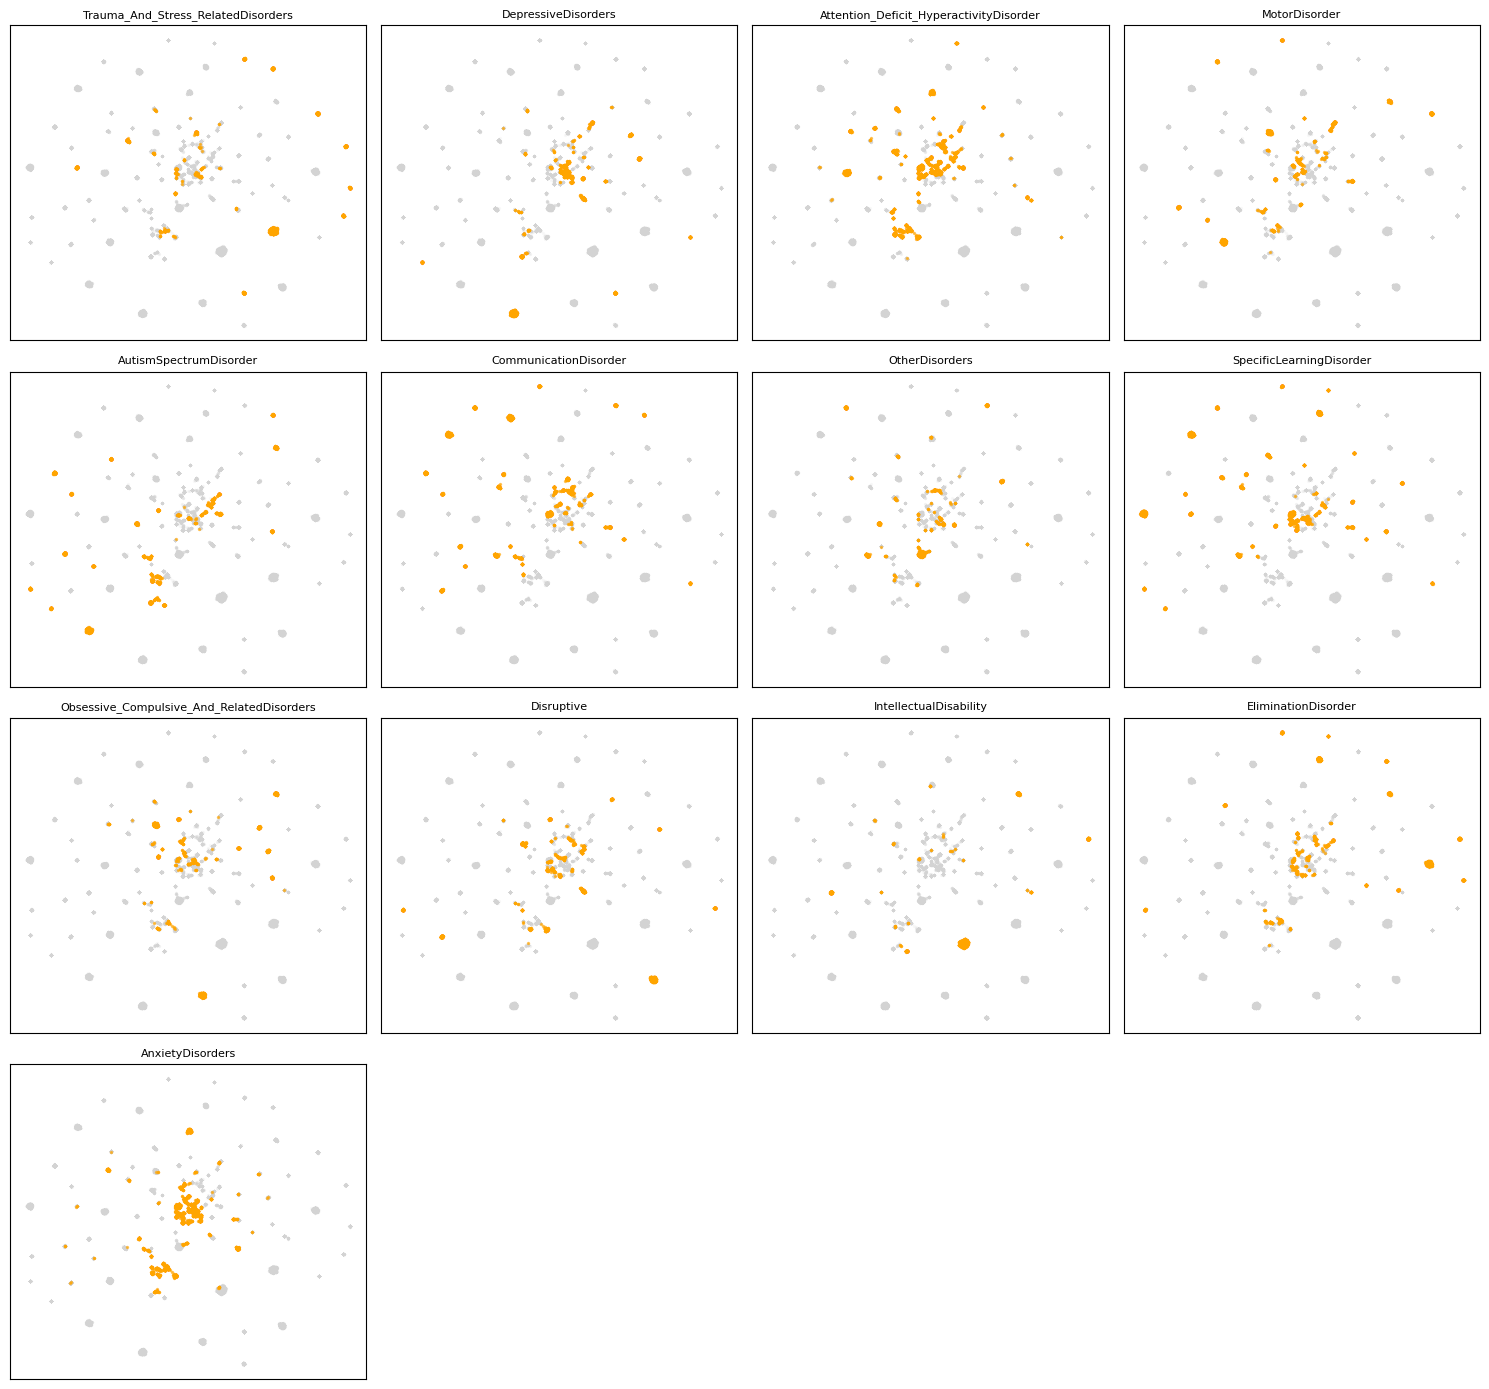

In [17]:
plot_umap_cluster(Y_over, 'oversampled', ebd)

# 3. Morphometric features

## 3.1. Relationship between eTIV and confounding variables (age, sex)

In [7]:
F = features.iloc[:,1:]
TIV = F['global_estimatedtotalintracranialvol']

In [9]:
AGE = C['Age']
SEX = C['Sex']

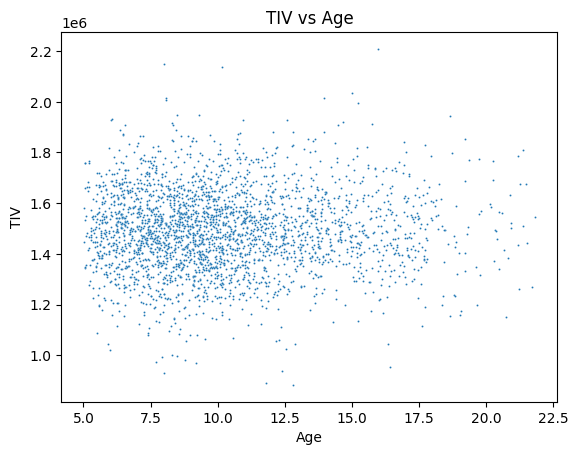

In [11]:
sns.scatterplot(x=AGE, y=TIV, s=2)
plt.xlabel('Age')
plt.ylabel('TIV')
plt.title('TIV vs Age')
plt.show()


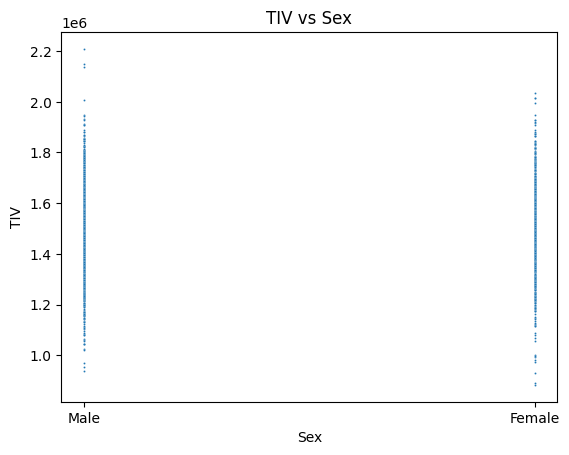

In [13]:
sns.scatterplot(x=SEX, y=TIV, s=2)
plt.xlabel('Sex')
plt.ylabel('TIV')
plt.title('TIV vs Sex')
plt.show()


In [17]:
b_seg_vol = F['global_brainsegvol']

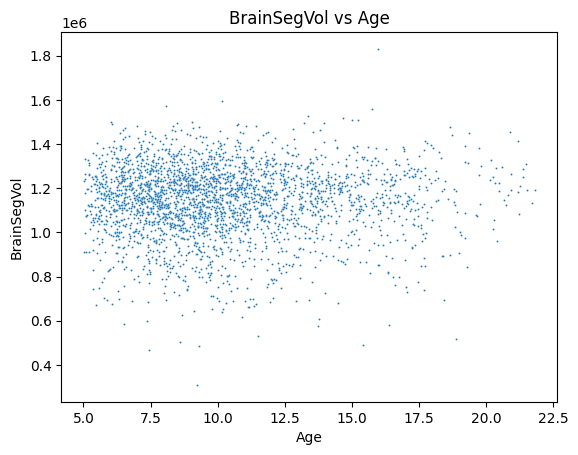

In [18]:
sns.scatterplot(x=AGE, y=b_seg_vol, s=2)
plt.xlabel('Age')
plt.ylabel('BrainSegVol')
plt.title('BrainSegVol vs Age')
plt.show()

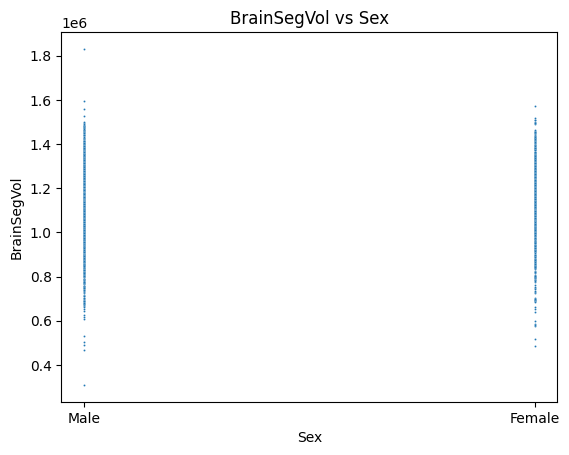

In [20]:
sns.scatterplot(x=SEX, y=b_seg_vol, s=2)
plt.xlabel('Sex')
plt.ylabel('BrainSegVol')
plt.title('BrainSegVol vs Sex')
plt.show()


In [21]:
total_gray_vol = F['global_totalgrayvol']

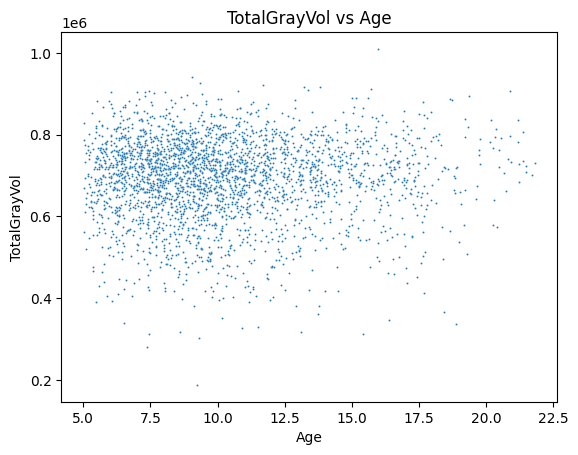

In [22]:
sns.scatterplot(x=AGE, y=total_gray_vol, s=2)
plt.xlabel('Age')
plt.ylabel('TotalGrayVol')
plt.title('TotalGrayVol vs Age')
plt.show()

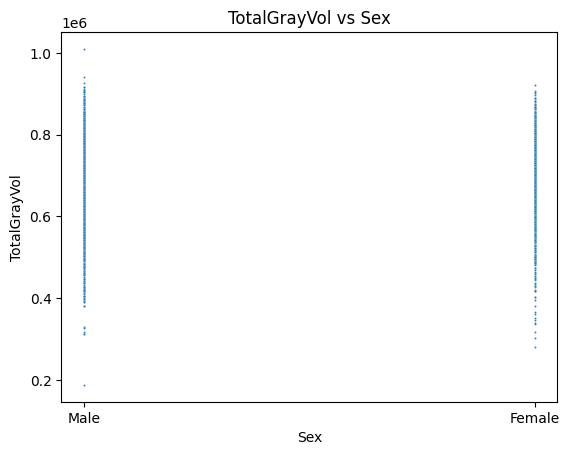

In [23]:
sns.scatterplot(x=SEX, y=total_gray_vol, s=2)
plt.xlabel('Sex')
plt.ylabel('TotalGrayVol')
plt.title('TotalGrayVol vs Sex')
plt.show()

# 4. Brain images